# BIONIC Methods Tests and Data Visualization

## Exploration and Gene Filtering

In [1]:
# imports
from itertools import combinations
import numpy as np
import pandas as pd
import csv
# import pearsonr as pearsonr
# from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import argparse
import networkx as nx

In [3]:
#File Read
# df = pd.read_csv("../outputs/previous_attemps/locus_tag_processed.csv", sep=',', index_col=0, header=0)
# df

In [207]:
# df.index.isna().sum()

0

### Pre-processes the probe names
Pre-processed the gene expression data, separating the probe names and removing the probes from organs (ATC and ATM).

In [208]:
# with open('../outputs/previous_attemps/locus_tag_processed.csv', 'r') as file:
#     reader = csv.reader(file)
#     header = next(reader)
#     new_rows = []
#
#     for row in reader:
#         probe_names = [row[0][i:i+9] for i in range(0, len(row[0]), 9)]
#
#         # Filter out probes from organs (ATC and ATM)
#         probe_names = [probe for probe in probe_names if not probe.startswith('ATC') and not probe.startswith('ATM')]
#
#         # Remove ATM and ATC from the list of probe names if they are aliases
#         for i in range(len(probe_names)):
#             if probe_names[i] == 'ATC' or probe_names[i] == 'ATM':
#                 probe_names.pop(i)
#
#         if len(probe_names) > 0:
#             new_row = [';'.join(probe_names)] + row[1:]
#             new_rows.append(new_row)
#
# with open('../outputs/probes_alias_sep.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(header)
#     writer.writerows(new_rows)

In [214]:
#File Read
# df = pd.read_csv("../outputs/current_df/probes_alias_sep.csv", sep=',', index_col=0, header=0)
# df.index.isna().sum()

0

###  Map probe names to gene symbols
Map the probe names to gene symbols.

In [211]:
# def map_probes_to_genes(input_file, mapping_file):
#     # Read the mapping file and create a dictionary mapping probe names to gene symbols
#     probe_to_gene = {}
#     with open(mapping_file, 'r') as map_file:
#         for line in map_file:
#             probe, gene = line.strip().split()
#             probe_to_gene[probe] = gene
#
#     # Read in the input file as a DataFrame
#     input_df = pd.read_csv(input_file)
#
#     # Map the gene symbols for each probe name
#     gene_symbols = []
#     for probe_name in input_df['probe_name']:
#         sub_probes = probe_name.split(';')
#         gene_symbol = ''
#         if len(sub_probes) > 1:
#             gene_symbol += ';'.join([probe_to_gene.get(sub_probe, sub_probe) for sub_probe in sub_probes])
#         else:
#             gene_symbol += probe_to_gene.get(sub_probes[0], sub_probes[0])
#         gene_symbols.append(gene_symbol)
#
#     # Replace the "probe_name" column with "gene_symbol"
#     input_df['gene_symbol'] = gene_symbols
#     input_df = input_df.drop(columns=['probe_name'])
#     input_df = input_df.set_index('gene_symbol')
#
#     # Write the output file
#     input_df.to_csv('../outputs/current_df/genesymb_processed.csv')
#
# map_probes_to_genes('../outputs/probes_alias_sep.csv', '../gene_mapping/gene_symbol_mapping.txt')

In [213]:
#File Read
# df = pd.read_csv("../outputs/current_df/genesymb_processed.csv", sep=',', index_col=0, header=0)
# df.index.isna().sum()

0

## Scaling and Filtering

In [5]:
#File Read
df = pd.read_csv("../outputs/previous_attemps/probes_alias_sep.csv", sep=',', index_col=0, header=0)
df

,35D-0H-16C-A,35D-0H-16C-B,35D-2H-16C-A,37D-2H-16C-B,40D-5H-16C-A,40D-5H-16C-B,44D-9H-16C-A,44D-9H-16C-B,37D-2H-25C-A,37D-2H-25C-B,40D-5H-25C-A,40D-5H-25C-B,44D-9H-25C-A,44D-9H-25C-B
probe_name,,,,,,,,,,,,,,
AT2G42240,110.0,95.2,91.1,133.4,97.2,121.3,85.2,125.7,92.9,127.4,92.7,102.4,102.5,112.5
AT2G42250,28.5,27.2,34.2,29.3,28.4,30.5,18.5,24.6,26.7,12.0,42.5,35.3,21.9,31.7
AT2G42270,87.8,89.8,72.2,83.4,86.0,85.2,108.0,66.4,91.0,94.6,98.6,76.5,81.6,86.3
AT2G42280,42.5,35.0,21.2,30.5,17.1,14.4,19.8,1.2,41.7,31.1,21.2,17.3,18.2,12.3
AT2G42120,262.4,282.2,248.7,266.0,209.7,235.3,204.1,289.5,228.7,213.9,248.7,275.3,233.3,246.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257585_at,4.0,6.4,5.8,9.2,1.8,1.9,17.7,2.8,8.3,2.0,4.0,10.6,5.5,1.8
AT1G50760,3.9,8.8,13.0,6.1,13.8,31.0,12.8,0.5,9.4,22.8,14.7,5.5,27.7,1.5
AT1G56310,153.5,148.0,78.4,112.0,97.2,114.7,109.8,112.8,93.4,105.7,101.7,91.2,89.2,81.6


In [6]:
# Check the value ranges of the expression values for each conditions
grouped_data = df.groupby(df.columns, axis=1)
grouped_data.describe()

,,count,mean,std,min,25%,50%,75%,max
35D-0H-16C-A,35D-0H-16C-A,22553.0,275.946020,697.108922,0.0,17.8,78.4,250.6,11717.7
35D-0H-16C-B,35D-0H-16C-B,22553.0,266.573037,630.579840,0.0,15.8,81.3,255.6,9982.1
35D-2H-16C-A,35D-2H-16C-A,22553.0,274.251581,680.855354,0.0,20.1,83.2,252.4,11184.2
37D-2H-16C-B,37D-2H-16C-B,22553.0,268.955412,648.300507,0.0,16.2,83.0,252.4,9832.8
37D-2H-25C-A,37D-2H-25C-A,22553.0,271.357150,660.357147,0.0,20.3,87.9,256.1,11547.8
37D-2H-25C-B,37D-2H-25C-B,22553.0,269.751080,659.436351,0.1,16.7,86.4,255.3,10688.8
40D-5H-16C-A,40D-5H-16C-A,22553.0,271.262497,657.703709,0.0,16.0,81.3,256.2,10244.4
40D-5H-16C-B,40D-5H-16C-B,22553.0,271.353314,668.348653,0.0,19.8,84.4,250.9,10996.7
40D-5H-25C-A,40D-5H-25C-A,22553.0,270.113759,652.476525,0.1,20.6,87.8,258.6,11045.5
40D-5H-25C-B,40D-5H-25C-B,22553.0,270.886463,670.787552,0.2,18.3,85.3,255.7,11509.6


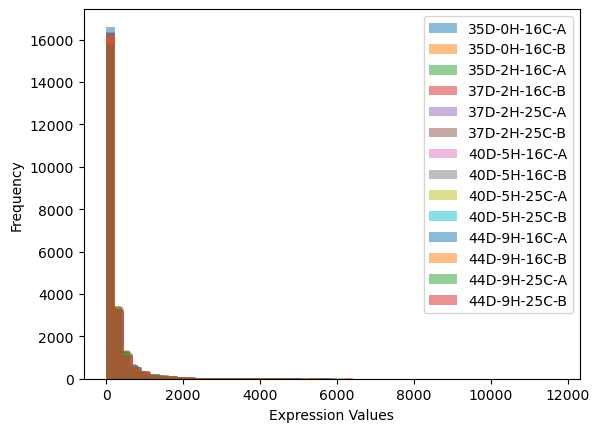

In [7]:
# Plot distribution of expression values for each condition

for sample, group in grouped_data:
    plt.hist(group[sample], bins=50, alpha=0.5, label=sample)

plt.xlabel("Expression Values")
plt.ylabel("Frequency")
plt.legend()

plt.show()

### Separate datasets by conditions

In [8]:
# Separate dataset by temperatures
sixteen_df = df.iloc[:, :8]
sixteen_df.to_csv("../outputs/separate_conditions/sixteen_df_probe.csv")
twenty_five_df = df.iloc[:, 8:16]
twenty_five_df.to_csv("../outputs/separate_conditions/twenty_five_df_probe.csv")

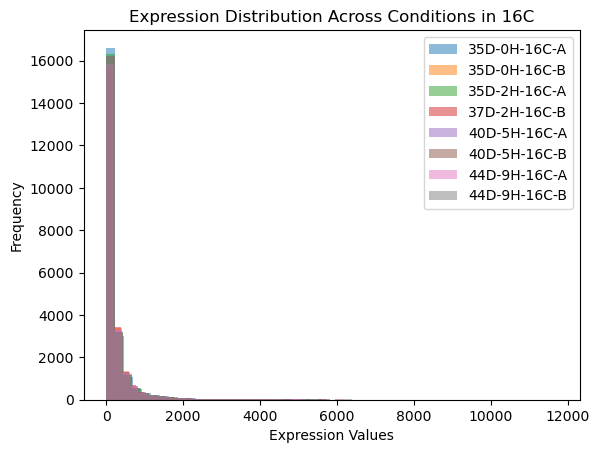

In [9]:
# Expression distribution across conditions in 16C
grouped_sixteen = sixteen_df.groupby(sixteen_df.columns, axis=1)

for sample, condition in grouped_sixteen:
    plt.hist(condition[sample], bins=50, alpha=0.5, label=sample)

plt.xlabel("Expression Values")
plt.ylabel("Frequency")
plt.title("Expression Distribution Across Conditions in 16C")
plt.legend()

plt.show()

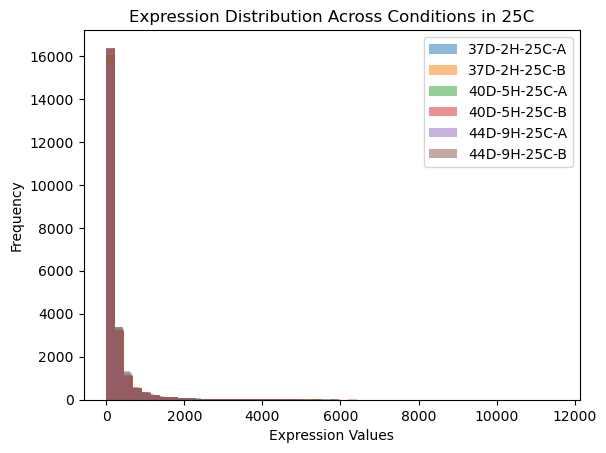

In [10]:
# Expression distribution across conditions in 25C
grouped_twenty_five = twenty_five_df.groupby(twenty_five_df.columns, axis=1)

for sample, condition in grouped_twenty_five:
    plt.hist(condition[sample], bins=50, alpha=0.5, label=sample)

plt.xlabel("Expression Values")
plt.ylabel("Frequency")
plt.title("Expression Distribution Across Conditions in 25C")
plt.legend()

plt.show()

### Filter by Coefficient of Variation

In [16]:
# Read condition files
sixteen_df = pd.read_csv("../outputs/separate_conditions/sixteen_df_probe.csv")
twenty_five_df = pd.read_csv("../outputs/separate_conditions/twenty_five_df_probe.csv")

In [22]:
sixteen_df.dropna(inplace=True)
sixteen_df.set_index('probe_name', inplace=True)

In [24]:
twenty_five_df.dropna(inplace=True)
twenty_five_df.set_index('probe_name', inplace=True)

In [25]:
# Calculate CoV for 16C

# Calculate the mean and standard deviation for each gene
sixteen_mean = sixteen_df.mean(axis=1)
sixteen_std = sixteen_df.std(axis=1)

# Calculate the coefficient of variation for each gene
sixteen_cv = (sixteen_std / sixteen_mean) * 100

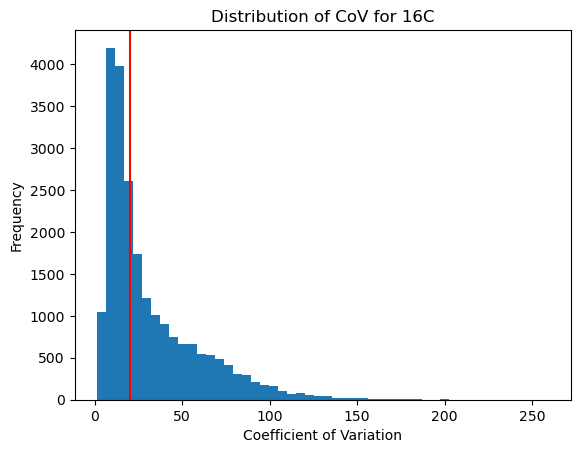

In [26]:
# Visualize CoV
plt.hist(sixteen_cv, bins=50)
plt.xlabel("Coefficient of Variation")
plt.ylabel("Frequency")
plt.title("Distribution of CoV for 16C")
plt.axline((20, 0), (20, 100), color='r')
plt.show()

In [27]:
# Filter out genes with a CV below 25%
threshold = 20
filtered_sixteen_genes = sixteen_cv[sixteen_cv >= threshold].index.tolist()
filtered_sixteen_df = sixteen_df.loc[filtered_sixteen_genes, :]
print(len(filtered_sixteen_genes))

11578


In [28]:
# Calculate CoV for 25C

# Calculate the mean and standard deviation for each gene
twenty_five_mean = twenty_five_df.mean(axis=1)
twenty_five_std = twenty_five_df.std(axis=1)

# Calculate the coefficient of variation for each gene
twenty_five_cv = (twenty_five_std / twenty_five_mean) * 100

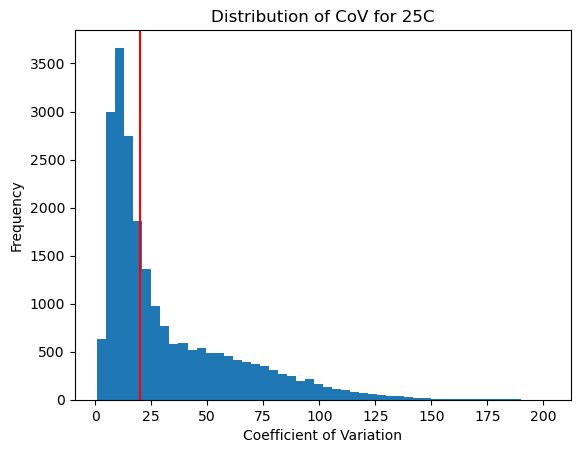

In [29]:
# Visualize CoV
plt.hist(twenty_five_cv, bins=50)
plt.xlabel("Coefficient of Variation")
plt.ylabel("Frequency")
plt.title("Distribution of CoV for 25C")
plt.axline((20, 0), (20, 100), color='r')
plt.show()

In [30]:
# Filter out genes with a CV below 25%
threshold = 20
filtered_cov_twentyfive_genes = twenty_five_cv[twenty_five_cv >= threshold].index.tolist()
filtered_twentyfive_cov_df = twenty_five_df.loc[filtered_cov_twentyfive_genes, :]
print(len(filtered_cov_twentyfive_genes))

10999


### Filter by Mean Absolute Deviation

In [31]:
# Calculate MAD for each gene in 16C

sixteen_mad = np.mean(np.abs(sixteen_df - sixteen_df.mean()), axis=1)
sixteen_median_mad = np.median(sixteen_mad)

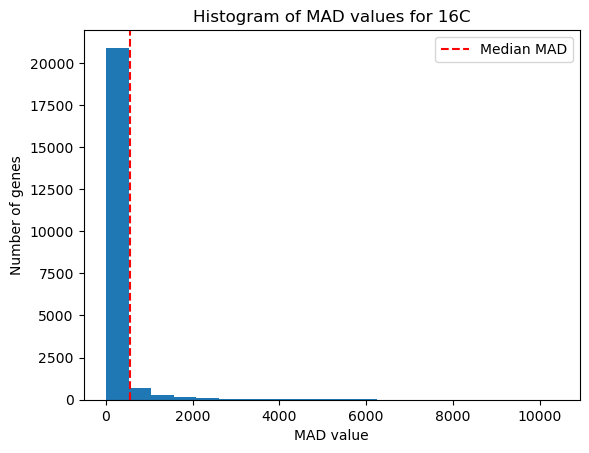

In [32]:
# Visualize MAD values
median_threshold = sixteen_median_mad * 2.4
plt.hist(sixteen_mad, bins=20)
plt.axvline(x=median_threshold, color='red', linestyle='--', label='Median MAD', )
plt.xlabel('MAD value')
plt.ylabel('Number of genes')
plt.title('Histogram of MAD values for 16C')
plt.legend()
plt.show()

In [33]:
# Filter out by the median of the MAD value
median_threshold = sixteen_median_mad * 2.4
filtered_sixteen_mad = sixteen_df.loc[sixteen_mad >= median_threshold, :]
print(len(filtered_sixteen_mad))

1484


In [34]:
# Calculate MAD for each gene in 25C

twenty_five_mad = np.mean(np.abs(twenty_five_df - twenty_five_df.mean()), axis=1)
twenty_five_median_mad = np.median(twenty_five_mad)

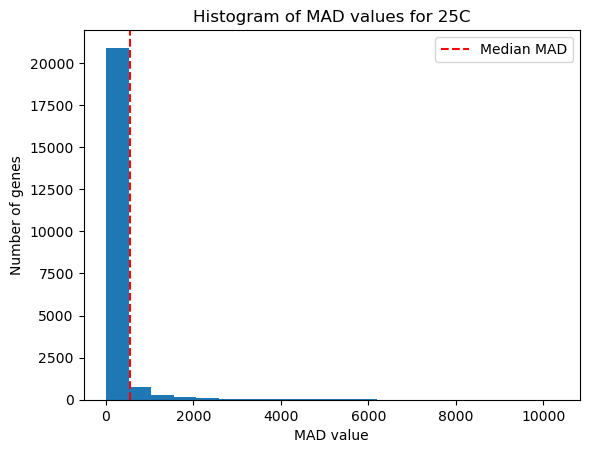

In [35]:
# Visualize MAD values for 25C
median_threshold = twenty_five_median_mad * 2.4
plt.hist(twenty_five_mad, bins=20)
plt.axvline(x=median_threshold, color='red', linestyle='--', label='Median MAD', )
plt.xlabel('MAD value')
plt.ylabel('Number of genes')
plt.title('Histogram of MAD values for 25C')
plt.legend()
plt.show()

In [36]:
# Filter out by the median of the MAD value
filtered_twenty_five_mad = twenty_five_df.loc[twenty_five_mad >= median_threshold, :]
print(len(filtered_twenty_five_mad))

1483


In [37]:
# Check if filtered genes from both conditions match
filtered_sixteen_mad_genes = filtered_sixteen_mad.index.tolist()
filtered_twenty_five_mad_genes = filtered_twenty_five_mad.index.tolist()
print(len(filtered_sixteen_mad_genes))
print(len(filtered_twenty_five_mad_genes))
print(len(set(filtered_sixteen_mad_genes).intersection(filtered_twenty_five_mad_genes)))

1484
1483
1310


In [38]:
filtered_twenty_five_mad

,37D-2H-25C-A,37D-2H-25C-B,40D-5H-25C-A,40D-5H-25C-B,44D-9H-25C-A,44D-9H-25C-B
probe_name,,,,,,
AT2G42210,2913.2,2294.4,2580.2,2314.7,2559.5,2477.0
AT2G33040,2106.4,2437.6,2116.1,2451.6,1974.5,2292.9
AT2G39700,821.4,834.3,1207.4,907.2,902.7,1023.0
AT2G32180;AT2G32650,923.6,811.2,677.9,877.0,926.7,844.5
AT2G45710,875.2,697.2,796.1,769.4,905.9,845.5
...,...,...,...,...,...,...
AT2G26500,2736.0,2614.8,2347.7,2196.2,2346.9,2673.3
AT2G26510,958.8,894.1,1054.4,989.7,973.5,956.5
AT2G07783,1813.6,1284.2,1707.6,1344.3,1680.5,1393.2


## Scale filtered datasets

In [240]:
# Scale values by individual samples
scaler_sixteen_cov = StandardScaler()
scaled_sixteen_cov = scaler_sixteen_cov.fit_transform(filtered_sixteen_df)
scaled_sixteen_cov = pd.DataFrame(scaled_sixteen_cov, columns=filtered_sixteen_df.columns, index=filtered_sixteen_df.index)
scaled_sixteen_cov.to_csv("../outputs/separate_conditions/scaled_sixteen_cov.csv")

In [241]:
scaler_twentyfive_cov = StandardScaler()
scaled_twenty_five_cov = scaler_twentyfive_cov.fit_transform(filtered_twentyfive_cov_df)
scaled_twenty_five_cov = pd.DataFrame(scaled_twenty_five_cov, columns=filtered_twentyfive_cov_df.columns, index=filtered_twentyfive_cov_df.index)
scaled_twenty_five_cov.to_csv("../outputs/separate_conditions/scaled_twenty_five_cov.csv")

In [39]:
scaler_sixteen_mad = StandardScaler()
scaled_sixteen_mad = scaler_sixteen_mad.fit_transform(filtered_sixteen_mad)
scaled_sixteen_mad = pd.DataFrame(scaled_sixteen_mad, columns=filtered_sixteen_mad.columns, index=filtered_sixteen_mad.index)
scaled_sixteen_mad.to_csv("../outputs/separate_conditions/scaled_sixteen_mad_probe.csv")

In [40]:
scaler_twentyfive_mad = StandardScaler()
scaled_twenty_five_mad = scaler_twentyfive_mad.fit_transform(filtered_twenty_five_mad)
scaled_twenty_five_mad = pd.DataFrame(scaled_twenty_five_mad, columns=filtered_twenty_five_mad.columns, index=filtered_twenty_five_mad.index)
scaled_twenty_five_mad.to_csv("../outputs/separate_conditions/scaled_twenty_five_mad_probe.csv")

In [43]:
features = pd.read_csv('../bionic/filtered_run_probes/filtered_probe_features.tsv', sep='\t', index_col=0)
features

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
255020_at,-0.006247,-0.018149,-0.017423,0.007149,-0.003008,0.001931,-0.013289,-0.005034,0.006244,0.001750,...,-0.008911,0.003995,0.017557,0.002991,-0.000345,0.005529,0.002056,-0.014726,0.004361,0.001229
AT1G01050,0.004830,0.011169,0.003792,0.017788,-0.014246,-0.000641,-0.025819,0.000021,0.017915,-0.013237,...,-0.010560,0.007139,0.012775,0.009315,0.008101,0.013099,0.000828,0.001848,0.008250,0.008725
AT1G01060,-0.001470,-0.005974,-0.001811,0.000743,-0.012878,0.018293,-0.037674,0.012846,-0.017429,0.013586,...,-0.011469,0.001756,-0.001960,-0.003273,-0.013477,0.003121,0.020154,0.008089,-0.008059,-0.007881
AT1G01090,-0.009944,-0.006140,-0.007729,0.007641,0.012065,0.009763,-0.022800,-0.000087,0.000417,-0.002282,...,-0.012605,-0.004595,0.007947,0.021541,0.009645,-0.009755,-0.007326,0.002124,-0.004493,0.010684
AT1G01100,-0.006866,-0.007333,-0.011319,0.007307,0.001118,0.004682,-0.010327,0.012036,0.017008,-0.016681,...,0.006309,-0.003346,-0.007550,0.004102,-0.005310,0.004469,0.003840,-0.002304,0.007110,-0.001899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT5G67070,-0.000543,0.004945,0.008285,0.002662,0.018084,0.002193,-0.018596,0.025533,0.015722,0.004437,...,-0.011465,-0.002589,0.000824,0.014296,0.002529,0.011207,-0.002502,-0.005919,0.002629,-0.007259
AT5G67260,-0.005484,-0.007999,-0.007287,-0.008406,-0.000317,0.007417,-0.016193,0.003856,-0.003856,0.017619,...,-0.016871,-0.002877,0.008963,0.015760,-0.001487,-0.005412,0.006198,-0.005678,0.017054,0.004524
AT5G67360,0.007261,-0.008461,-0.013153,0.007251,-0.000740,0.019082,-0.019638,0.011173,0.015940,-0.004521,...,0.000960,0.007934,0.012270,0.013914,0.007874,0.001108,-0.000656,-0.001405,0.011548,-0.010984
AT5G67510,-0.000081,-0.015658,-0.014469,-0.012736,0.009214,0.009731,-0.008358,0.011219,0.002304,-0.014356,...,-0.003239,-0.000117,0.007464,0.000387,0.014308,0.023721,0.021264,-0.015979,0.027706,0.005451


## Degree Distribution Plot
Plots the probability of distribution of the network's degrees

In [ ]:
def average_node_connection(edgelist_file):
    """
    Computes the average of node's connections.
    :param edgelist_file: Edgelist file that contains the network information.
    :return: Number of average connections
    """



In [22]:
# Degree distribution for 16C
import networkx as nx

# Read edgelist file into a numpy array
edgelist16 = np.loadtxt('../outputs/current_df/sixteencov_edgelist.txt', dtype='str')

# Convert weights column to float data type
edgelist16[:, 2] = edgelist16[:, 2].astype(np.float64)

# Create a networkx graph object from the edgelist
G16 = nx.Graph()
G16.add_weighted_edges_from(edgelist16)

# Calculate degree of each node in the graph
degrees16 = dict(G16.degree())

# Plot degree distribution as a histogram
plt.hist(list(degrees16.values()), bins=50)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('degree_distribution16cov.png')
plt.show()

MemoryError: 

## Network average degree
Average degree is the average number of edges per node in a graph.

In [2]:
df = pd.read_csv('../outputs/current_df/sixteencov_edgelist_995corr.txt', sep='\t', header=None, names=['source', 'target', 'weight'])

num_nodes = len(pd.unique(df[['source', 'target']].values.ravel('K'))) # selects the nodes cols, flattening it to a 1D array (so the unique function can work) and returning the number of unique values

degrees = pd.concat([df['source'], df['target']]).value_counts()
avg_degree = degrees.mean()

print(f"The network has {num_nodes} nodes and {len(df)} edges.")
print(f"The network has an average degree of {avg_degree:.2f}.")

The network has 10822330 nodes and 11560603 edges.
The network has an average degree of 1.07.


In [11]:
# Average Degree with NX function
edgelist = np.loadtxt('../outputs/current_df/sixteencov_edgelist_995corr.txt', dtype='str')

G = nx.Graph()
G.add_weighted_edges_from(edgelist)

num_nodes = G.number_of_nodes() # get the number of nodes in the graph
avg_degree = sum(dict(G.degree()).values()) / num_nodes # calculate the average degree of the nodes in the graph

print(f"The network has {num_nodes} nodes and {G.number_of_edges()} edges.")
print(f"The network has an average degree of {avg_degree:.2f}.")

MemoryError: Unable to allocate 19.9 GiB for an array with shape (11560603, 3) and data type <U154

In [ ]:
def degree_distribution(edgelist_file, output_file):
    # Read edgelist file into a numpy array
    edgelist = np.loadtxt(edgelist_file, dtype='str')

    # Convert weights column to float data type
    edgelist[:, 2] = edgelist[:, 2].astype(np.float64)

    # Create a networkx graph object from the edgelist
    G = nx.Graph()
    G.add_weighted_edges_from(edgelist)

    # Calculate degree of each node in the graph
    degrees = dict(G.degree())

    # Plot degree distribution as a histogram
    plt.hist(list(degrees.values()), bins=50)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.savefig(output_file)
    plt.show()

if __name__ == '__main__':
    # Define command line arguments
    parser = argparse.ArgumentParser(description='Calculate and plot the degree distribution of a graph')
    parser.add_argument('output_file', type=str, help='The output file name for the degree distribution plot')

    # Parse arguments
    args = parser.parse_args()

    # Call function with arguments
    degree_distribution(args.input_file, args.output_file)

In [2]:
with open("../bionic/bionic_evals/feature-module-labels.txt", "r") as f:
    lines = f.readlines()

num_rows = len(lines)

print("Number of rows in the file:", num_rows)

Number of rows in the file: 1383


In [3]:
with open("../bionic/bionic_evals/network-module-labels.txt", "r") as f:
    lines = f.readlines()

num_rows = len(lines)

print("Number of rows in the file:", num_rows)

Number of rows in the file: 1383


## CLuster Visualization

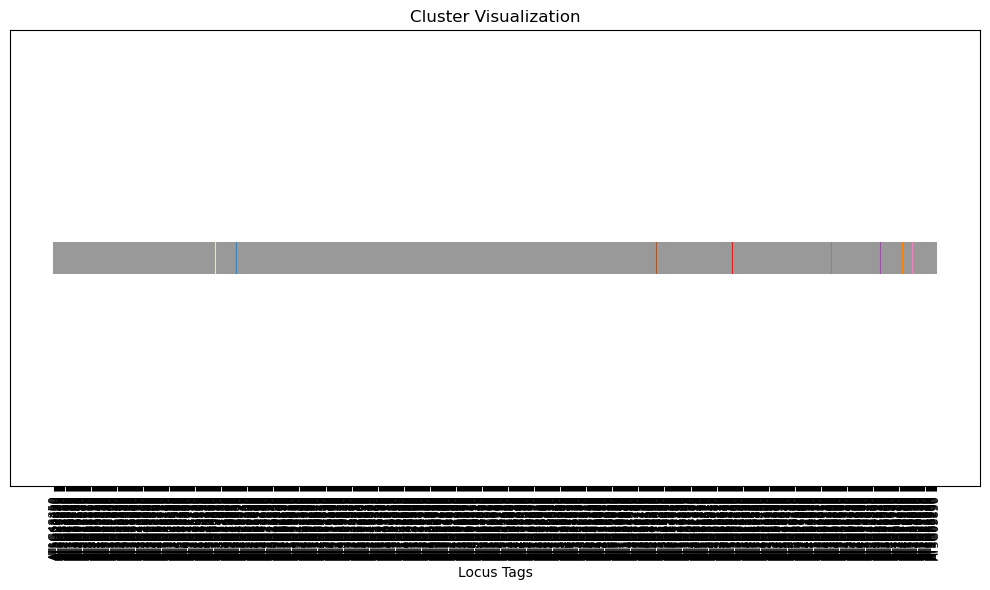

In [2]:
import matplotlib.pyplot as plt

# Read the text file with locus tags and cluster labels
with open('../bionic/bionic_evals/network-cluster-labels1.txt', 'r') as file:
    lines = file.readlines()

# Extract locus tags and cluster labels from the text file
locus_tags = []
cluster_labels = []
for line in lines:
    tag, label = line.strip().split('\t')
    locus_tags.append(tag)
    cluster_labels.append(label)

# Visualize the clusters
# Assign a unique color to each cluster label
unique_labels = list(set(cluster_labels))
label_colors = {label: i for i, label in enumerate(unique_labels)}

# Plot the clusters using locus tags as x-axis and cluster labels as colors
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(locus_tags)):
    x = i
    y = 0
    color = label_colors[cluster_labels[i]]
    ax.scatter(x, y, color=plt.cm.Set1(color), marker='|', s=500)

# Set the x-axis tick labels as locus tags
ax.set_xticks(range(len(locus_tags)))
ax.set_xticklabels(locus_tags, rotation=90, fontsize=8)

# Remove y-axis
ax.get_yaxis().set_visible(False)

# Set plot title and labels
plt.title('Cluster Visualization')
plt.xlabel('Locus Tags')

# Show the plot
plt.tight_layout()
plt.show()


In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Read the text file with locus tags and cluster labels
with open('../bionic/bionic_evals/network-cluster-labels1.txt', 'r') as file:
    lines = file.readlines()

# Create a NetworkX graph
graph = nx.Graph()

# Extract locus tags and cluster labels from the text file
locus_tags = []
cluster_labels = []
for line in lines:
    tag, label = line.strip().split('\t')
    locus_tags.append(tag)
    cluster_labels.append(label)

# Add nodes (locus tags) and edges (cluster connections) to the graph
for i in range(len(locus_tags)):
    graph.add_node(locus_tags[i])
    for j in range(i + 1, len(locus_tags)):
        if cluster_labels[i] == cluster_labels[j]:
            graph.add_edge(locus_tags[i], locus_tags[j])

# Visualize the graph
pos = nx.spring_layout(graph)  # Layout algorithm for node positioning

plt.figure(figsize=(10, 6))
nx.draw_networkx(graph, pos=pos, node_color=[label_colors[cluster_labels[n]] for n in graph.nodes()],
                 node_size=200, edge_color='gray', alpha=0.7, with_labels=True)

# Set plot title
plt.title('Cluster Network Visualization')

# Show the plot
plt.tight_layout()
plt.show()

TypeError: list indices must be integers or slices, not str

<Figure size 1000x600 with 0 Axes>